<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
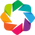

In [27]:
from pathlib import Path
import json
import pyarrow
import math
import re
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from scipy.stats import gaussian_kde
from scipy.ndimage import label
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import holoviews as hv
from holoviews import opts

hv.extension("bokeh")

from shiny import App, Inputs, Outputs, Session, reactive, render, req, ui

from utils_behavior import (
    Sleap_utils,
    HoloviewsTemplates,
    Utils,
    Processing,
    Ballpushing_utils,
    Seaborn_Templates,
)

import Config

import importlib

In [28]:
# Short contacts

Transformed = pd.read_feather("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/Skeleton_TNT/240120_short_contacts_no_cutoff_no_downsample_Data/Transformed_contacts_nocutoff_flexible_rule.feather")

In [29]:
Transformed = Config.cleanup_data(Transformed)

Transformed = Config.map_split_registry(Transformed)

In [5]:
Transformed

,duration,fly,start,end,start_frame,end_frame,x_Head_vel_mean,y_Head_vel_mean,x_Thorax_vel_mean,y_Thorax_vel_mean,...,Date,Genotype,Period,FeedingState,Orientation,Light,Crossing,contact_index,Simplified Nickname,Split
0,15,231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1,2455.344828,2455.827586,71205,71219,0.006781,0.050782,0.223546,0.064651,...,231115,TNTxG53,PM14,starved_noWater,std,on,1,1,JON-AB,n
1,55,231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1,1282.827586,1284.689655,37202,37256,0.004604,-0.144219,0.007459,-0.209500,...,231115,TNTxG53,PM14,starved_noWater,std,on,1,0,JON-AB,n
2,57,231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1,2890.517241,2892.448276,83825,83881,0.213138,-0.223613,0.225098,-0.226947,...,231115,TNTxG53,PM14,starved_noWater,std,on,1,2,JON-AB,n
3,79,231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1,3091.137931,3093.827586,89643,89721,-0.008837,-0.062641,0.038530,-0.106051,...,231115,TNTxG53,PM14,starved_noWater,std,on,1,3,JON-AB,n
4,23,231115_TNT_Fine_1_Videos_Tracked_arena1_corridor1,3094.379310,3095.137931,89737,89759,0.034168,0.163663,0.167076,0.163857,...,231115,TNTxG53,PM14,starved_noWater,std,on,1,4,JON-AB,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356527,63,240221_TNT_Fine_3_Videos_Tracked_arena3_corridor6,3537.275862,3539.413793,102581,102643,0.077795,-0.060342,0.068797,-0.055531,...,240221,TNTxZ1678,PM16,starved_noWater,std,on,1,144,Capa-GAL4 4F,n
356528,317,240221_TNT_Fine_3_Videos_Tracked_arena3_corridor6,3553.275862,3564.172414,103045,103361,0.011863,-0.026494,0.011962,-0.036993,...,240221,TNTxZ1678,PM16,starved_noWater,std,on,1,145,Capa-GAL4 4F,n
356529,23,240221_TNT_Fine_3_Videos_Tracked_arena3_corridor6,3599.275862,3600.034483,104379,104401,0.027906,0.033166,-0.004669,0.032769,...,240221,TNTxZ1678,PM16,starved_noWater,std,on,1,148,Capa-GAL4 4F,n
356530,45,240221_TNT_Fine_3_Videos_Tracked_arena3_corridor6,3576.482759,3578.000000,103718,103762,-0.269360,-0.085777,-0.189669,-0.079584,...,240221,TNTxZ1678,PM16,starved_noWater,std,on,1,147,Capa-GAL4 4F,n


In [30]:
registries = Config.registries

In [31]:
Transformed["identifier"] = Transformed["fly"]+str(Transformed["contact_index"])

# Contact rates

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
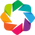

<module 'Config' from '/home/durrieu/Tracking_Analysis/MazeRecorder/Analysis/TNT_Sreen_Notebooks/Config.py'>

In [26]:
importlib.reload(Config)

In [24]:
Test = Config.get_subset_data(Transformed, value="R78A01 (ExR1 (EB))")

Nickname selected: R78A01 (ExR1 (EB))
Associated control is: Empty-Gal4


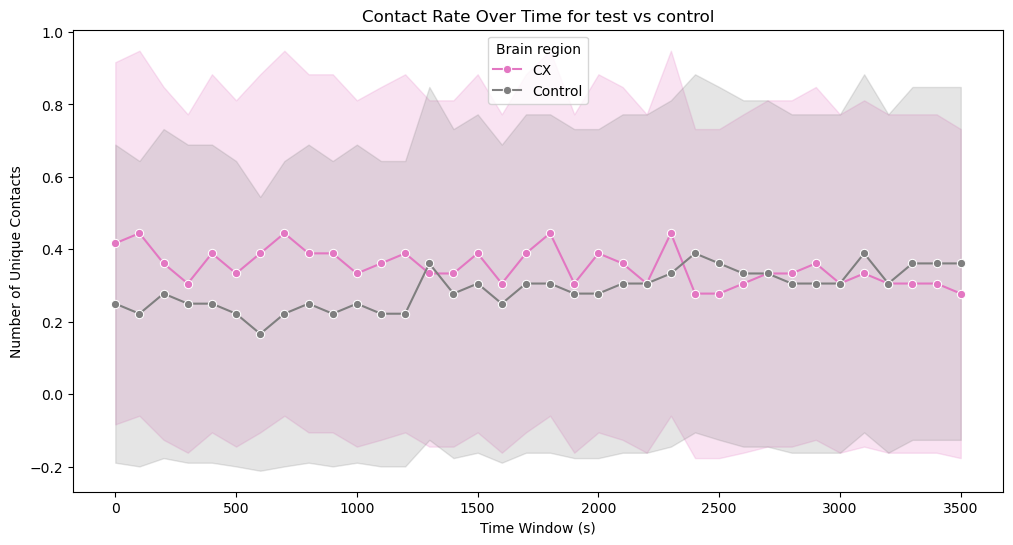

In [10]:
# Define the time window (e.g., 10 seconds)
time_window = 100

# Determine the maximum time in the dataset
max_time = Test['start'].max()

# Create bins for the time windows
bins = np.arange(0, max_time + time_window, time_window)

# Create a new column 'time_window' that indicates the time window each 'start' time belongs to
Test['time_window'] = pd.cut(Test['start'], bins=bins, right=False, labels=bins[:-1])

# Group by 'time_window', 'Brain region', and 'fly' and count the number of unique contacts in each time window
contact_rate = Test.groupby(['time_window', 'Brain region', 'fly'])['identifier'].nunique().reset_index()

# Rename the columns for clarity
contact_rate.columns = ['time_window', 'Brain region', 'fly', 'contact_count']

# Plot the contact rate over time with confidence intervals
plt.figure(figsize=(12, 6))
sns.lineplot(data=contact_rate, x='time_window', y='contact_count', hue='Brain region', marker='o', palette=Config.color_dict, ci='sd')
plt.xlabel('Time Window (s)')
plt.ylabel('Number of Unique Contacts')
plt.title(f'Contact Rate Over Time for test vs control')
plt.show()

Processed Brain region Control
Processed Brain region CX
Processed Brain region MB extrinsic neurons
Processed Brain region Vision
Processed Brain region MB
Processed Brain region LH
Processed Brain region Neuropeptide
Processed Brain region Olfaction
Error processing Miscellaneous Brain region: The palette dictionary is missing keys: {'DN'}
Processed Control Brain region


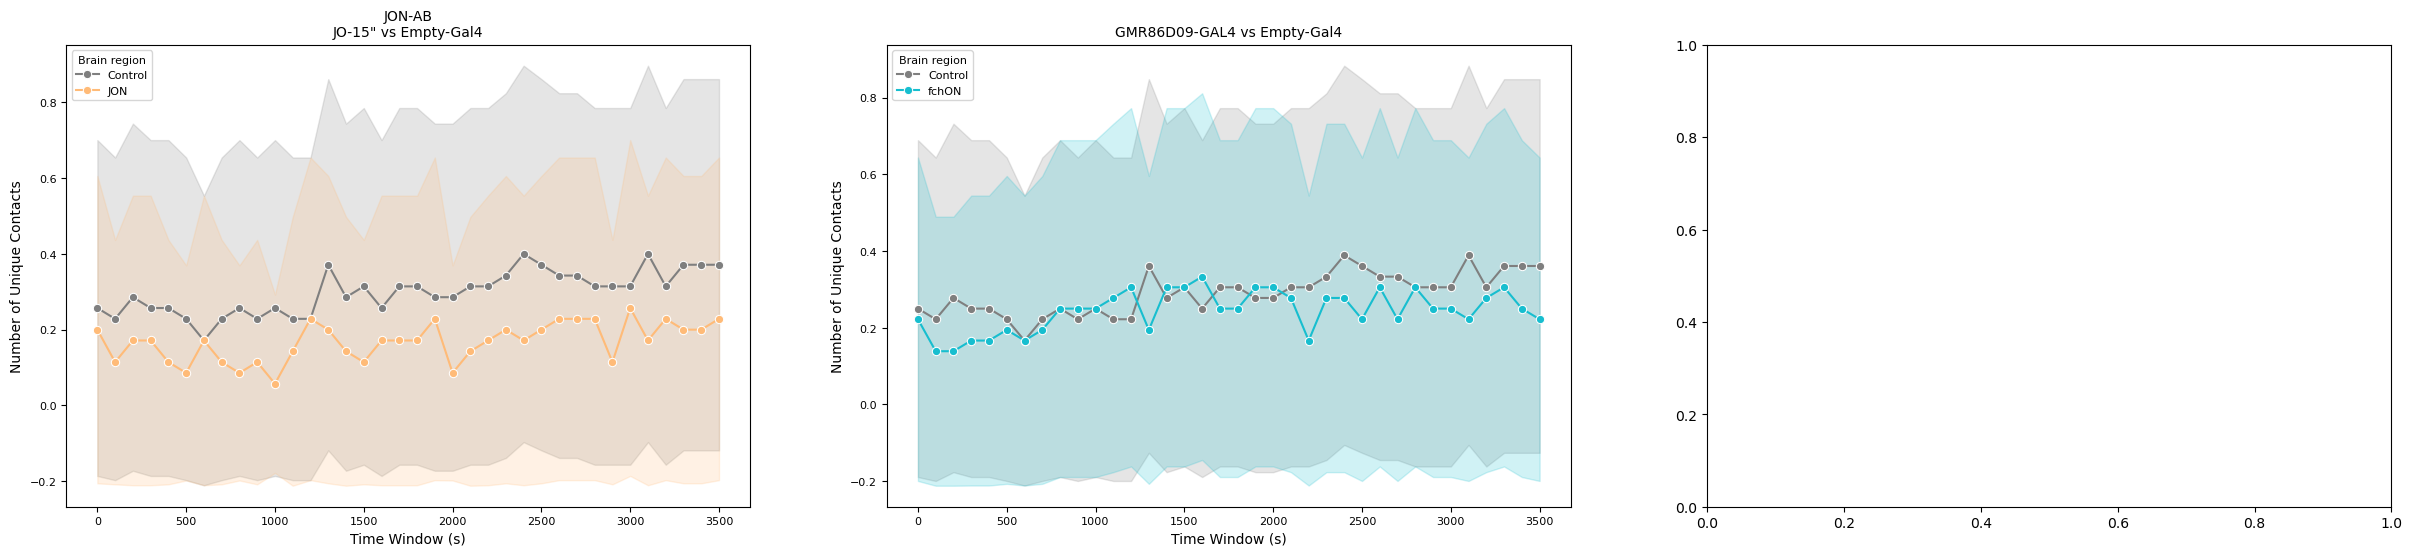

In [34]:
# Initialize random generator
rg = np.random.default_rng()

# Process brain regions
miscellaneous_nicknames = []
for brain_region in registries["brain_regions"]:
    output_path = f"/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/250124_contact_rates/KDE_ECDF_plots_{brain_region}.png"
    
    if os.path.exists(output_path):
        print(f"Skipping Brain region {brain_region} as the plot already exists.")
        continue
    
    region_data = Transformed[Transformed['Brain region'] == brain_region]
    nicknames = region_data['Nickname'].unique()
    
    if len(nicknames) < 5 and brain_region != "Control":
        miscellaneous_nicknames.extend(nicknames)
        continue
    
    try:
        Config.create_and_save_contact_rate_plot(Transformed, nicknames, brain_region, output_path, registries, Config.color_dict)
        print(f"Processed Brain region {brain_region}")
    except Exception as e:
        print(f"Error processing Brain region {brain_region}: {e}")

# Process Miscellaneous brain region
if miscellaneous_nicknames:
    try:
        output_path = "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/250124_contact_rates/KDE_ECDF_plots_Miscellaneous.png"
        Config.create_and_save_contact_rate_plot(Transformed, miscellaneous_nicknames, "Miscellaneous", output_path, registries, Config.color_dict)
        print("Processed Miscellaneous Brain region")
    except Exception as e:
        print(f"Error processing Miscellaneous Brain region: {e}")

# Plot the Control brain region
try:
    control_nicknames = registries["control_nicknames"]
    output_path = "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/250124_contact_rates/KDE_ECDF_plots_Control.png"
    Config.create_and_save_contact_rate_plot(Transformed, control_nicknames, "Control", output_path, registries, Config.color_dict)
    print("Processed Control Brain region")
except Exception as e:
    print(f"Error processing Control Brain region: {e}")

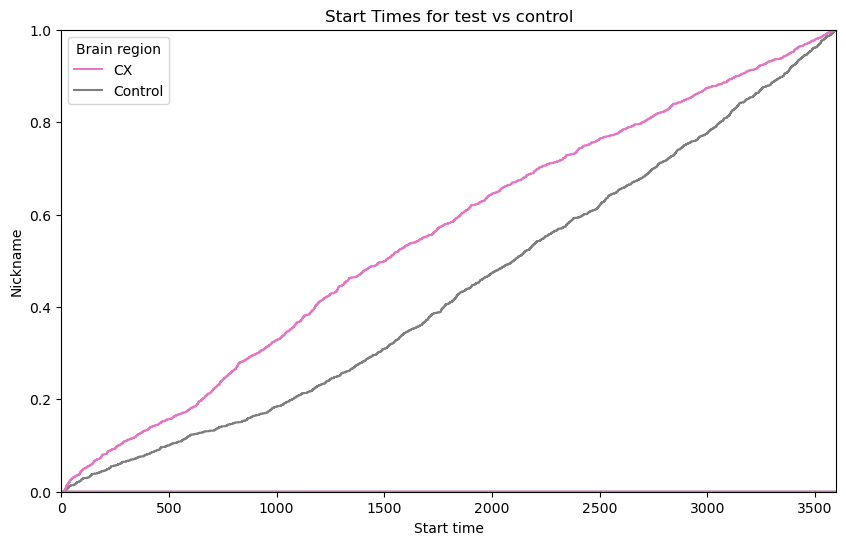

In [11]:
# Make a rugplot of the start times for the random Nickname

# Plot the subset data

plt.figure(figsize=(10, 6))

# Create the rugplot
sns.kdeplot(data=Test, x='start', hue='Brain region', palette=Config.color_dict)

sns.ecdfplot(data=Test, x='start', hue='Brain region', palette=Config.color_dict)

# set x axis limits to time window

plt.xlim(0, 3600)

# Set the title for the figure

plt.title(f'Start Times for test vs control')

# Set the axis labels

plt.xlabel('Start time')

plt.ylabel('Nickname')

# Show the plot

plt.show()

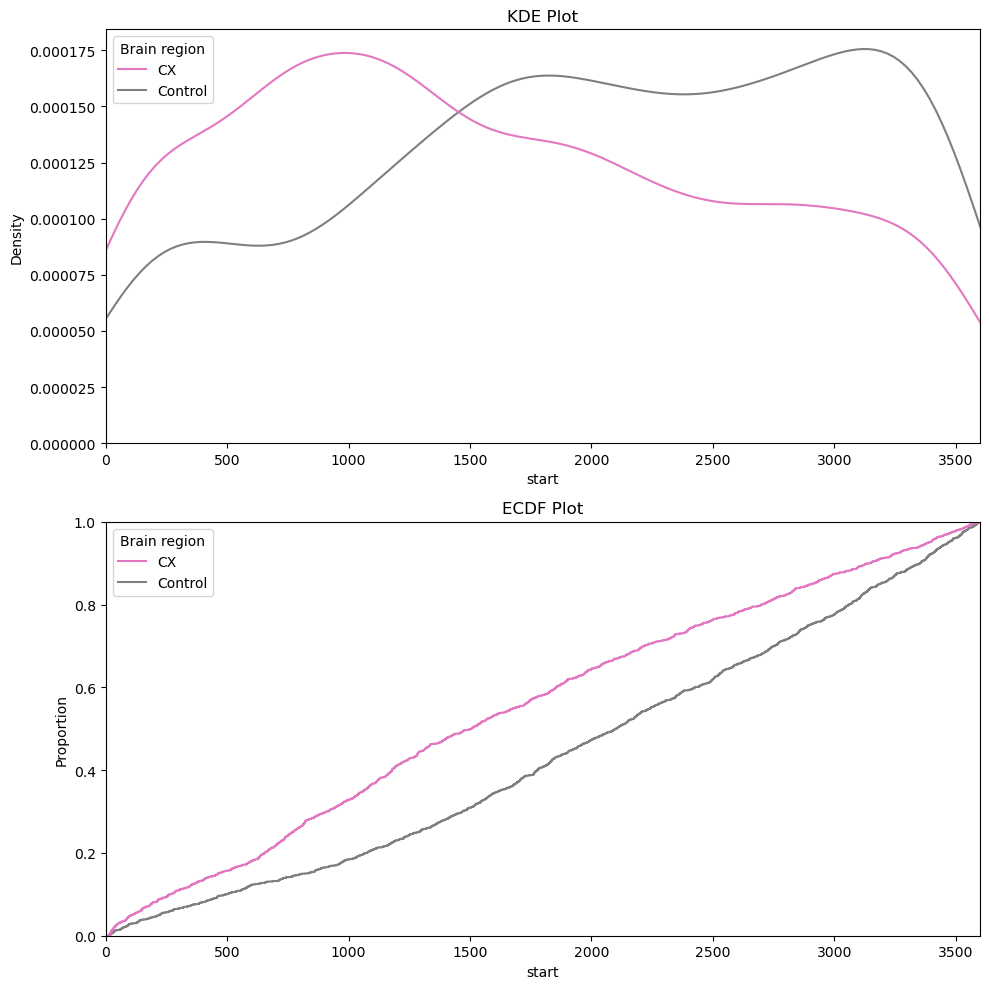

In [12]:

# Assuming 'data' is your dataset
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# KDE plot
sns.kdeplot(data=Test, x="start", ax=ax1, hue="Brain region", palette=Config.color_dict)
ax1.set_title("KDE Plot")

# adjust the x-axis limits
ax1.set_xlim(0, 3600)

# ECDF plot
sns.ecdfplot(data=Test, x="start", ax=ax2, hue="Brain region", palette=Config.color_dict)
ax2.set_title("ECDF Plot")

ax2.set_xlim(0, 3600)


plt.tight_layout()
plt.show()

In [ ]:

# Create time range
# Create time range using the existing second values
global_min = Test['start'].min()
global_max = Test['end'].max()

time_bins = np.linspace(global_min, global_max, 10+1)

Test[time_bins] = pd.cut(Test['start'], bins=time_bins, right=False, labels=time_bins[:-1])
# Count ongoing contacts
ongoing_contacts = []
for time in time_range:
    ongoing_count = ((Test['start'] <= time) & (Test['end'] >= time)).sum()
    ongoing_contacts.append(ongoing_count)

# Plot the ongoing contacts with seaborn colored by brain region

plt.figure(figsize=(12, 6))

# Create the lineplot

sns.lineplot(x=time_range, y=ongoing_contacts, hue=Test['Brain region'], palette=Config.color_dict)

# Set the title for the figure

plt.title('Ongoing Contacts Over Time')

# Set the axis labels

plt.xlabel('Time (s)')

plt.ylabel('Number of Ongoing Contacts')

# Show the plot

plt.show()

ValueError: array length 3590 does not match index length 1485

<Figure size 1200x600 with 0 Axes>

# Apply to whole dataset

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
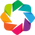

<module 'Config' from '/home/durrieu/Tracking_Analysis/MazeRecorder/Analysis/TNT_Sreen_Notebooks/Config.py'>

In [13]:
importlib.reload(Config)

In [ ]:
# Initialize random generator
rg = np.random.default_rng()

# Process brain regions
miscellaneous_nicknames = []
for brain_region in registries["brain_regions"]:
    output_path = f"/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/250120_KDE_ECDF/KDE_ECDF_plots_{brain_region}.png"
    
    if os.path.exists(output_path):
        print(f"Skipping Brain region {brain_region} as the plot already exists.")
        continue
    
    region_data = Transformed[Transformed['Brain region'] == brain_region]
    nicknames = region_data['Nickname'].unique()
    
    if len(nicknames) < 5 and brain_region != "Control":
        miscellaneous_nicknames.extend(nicknames)
        continue
    
    try:
        Config.create_and_save_kde_ecdf_plot(Transformed, nicknames, brain_region, output_path, registries)
        print(f"Processed Brain region {brain_region}")
    except Exception as e:
        print(f"Error processing Brain region {brain_region}: {e}")

# Process Miscellaneous brain region
if miscellaneous_nicknames:
    try:
        output_path = "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/250120_KDE_ECDF/KDE_ECDF_plots_Miscellaneous.png"
        Config.create_and_save_kde_ecdf_plot(Transformed, miscellaneous_nicknames, "Miscellaneous", output_path, registries)
        print("Processed Miscellaneous Brain region")
    except Exception as e:
        print(f"Error processing Miscellaneous Brain region: {e}")

# Plot the Control brain region
try:
    control_nicknames = registries["control_nicknames"]
    output_path = "/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/250120_KDE_ECDF/KDE_ECDF_plots_Control.png"
    Config.create_and_save_kde_ecdf_plot(Transformed, control_nicknames, "Control", output_path, registries)
    print("Processed Control Brain region")
except Exception as e:
    print(f"Error processing Control Brain region: {e}")